In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import pickle

import copy

import scipy.io as io

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline

from skimage import measure
from skimage.filters import gaussian

from impdar import *

from autopicker_methods import *

In [2]:
#files on disk
green_image = '../images/nline5.png'
green_mat = '../data/nline5_migtk_cropped.mat'

#load in data
dat = io.loadmat(green_mat)
data = dat['data']

#original image
mini = -8.774235248565674
maxi = 9.667154026031533

### Data cropping thoughts:

Is there some way to make this automatic? For instance, Ben mentioned that we could look at the power of the bed, and then set some cutoff value. So look at the bed and say: what is the **minimum** value where this criteria is met? For flat beds, this would work well. But for not so flat beds, this could be problematic because you would not pick as many internal reflectors that dip down to follow the bed.

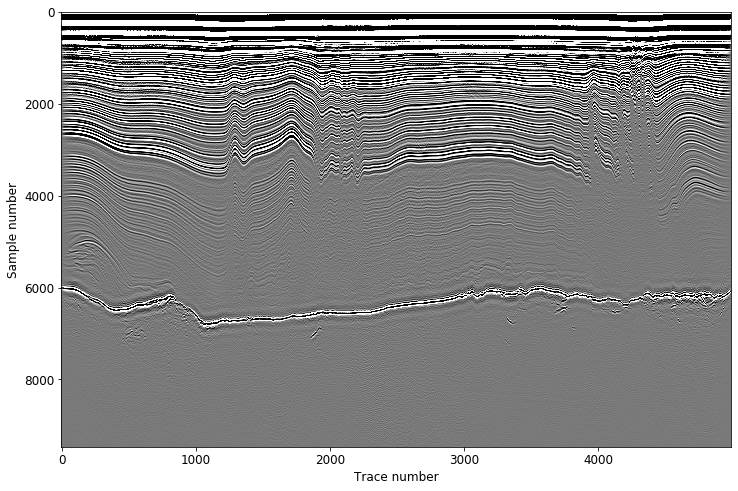

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.xlabel('Trace number', fontsize=12)
plt.ylabel('Sample number', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

### Contouring

In [4]:
#get positive and negative contours
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

In [5]:
#save contours and their lengths to lists
c_pos, c_neg, c_length_pos, c_length_neg = [], [], [], []

In [6]:
#positive contours
for contour in pos:
    c_pos.append(contour)

#negative contours
for contour in neg:
    c_neg.append(contour)

#now extract long contours
#this could be done instead of filtering?
for contour in pos:
    c_length_pos.append(len(contour))
    
for contour in neg:
    c_length_neg.append(len(contour))

In [7]:
#find the longest contour
print(np.argmax(c_length_pos))
print(c_length_pos[38])

print(np.argmax(c_length_neg))
print(c_length_neg[298])

#create an iterable list of the contours that are longer than some arbitrary value
long_contours_pos_idx = list(np.where(np.array(c_length_pos) > 250)[0])
long_contours_neg_idx = list(np.where(np.array(c_length_neg) > 250)[0])

38
44400
298
30373


In [8]:
long_contours_pos = [pos[idx] for idx in long_contours_pos_idx]
long_contours_neg = [neg[idx] for idx in long_contours_neg_idx]

In [9]:
#isolate some internal reflectors
long_contours_subset = long_contours_pos[22:100]

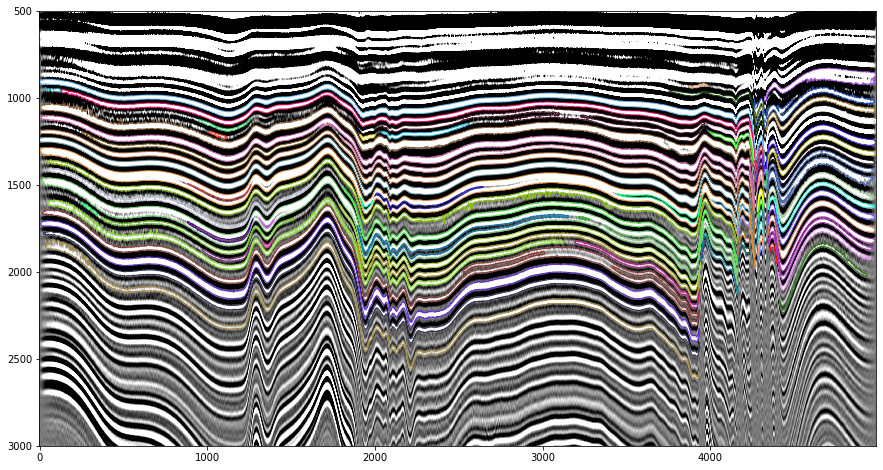

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i, contour in enumerate(long_contours_subset):
    plt.plot(contour[:, 1], contour[:, 0], color=np.random.rand(3,), linewidth=1)
    
ax.set_ylim(3000, 500)

plt.show()

### find end points

In [11]:
z = 1
argx1 = np.argmin(long_contours_subset[z][:, 1])
argx2 = np.argmax(long_contours_subset[z][:, 1])

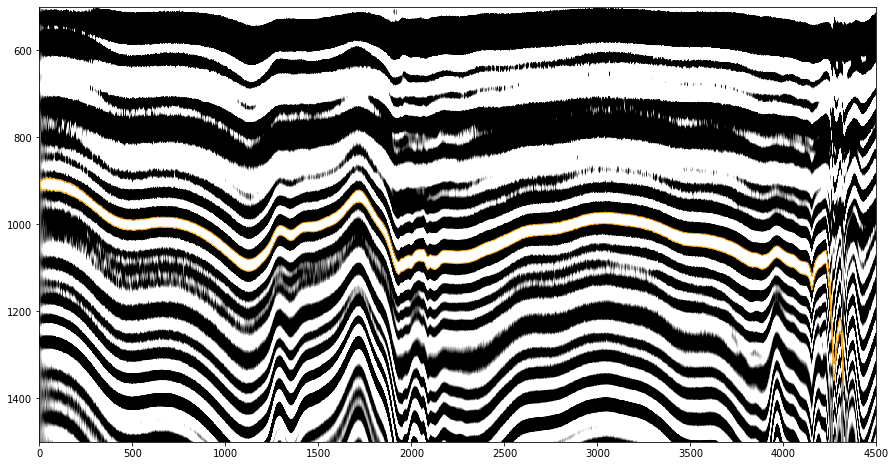

In [12]:
fig, ax = plt.subplots(figsize=(15, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(long_contours_subset[z][:, 1], long_contours_subset[z][:, 0], color='orange', linewidth=1)

ax.set_xlim(0, 4500)
ax.set_ylim(1500, 500)

plt.show()

In [13]:
uniquex = (list(set([int(x) for x in long_contours_subset[z][:, 1]])))

In [14]:
saved_points2 = []
delete = []

for i, x in enumerate(uniquex):
    wherex = np.where(long_contours_subset[1][:, 1]==x)[0]
    if len(wherex) == 0:
        delete.append(x)
    else:
        if len(wherex) > 2:
            saved_points2.append(wherex[1:3])
            #print(i, wherex[1:3])
        else:
            saved_points2.append(wherex)
            #print(i, wherex)
            
uniquex = [x for x in uniquex if x not in delete]

### find y values, ridge points

In [15]:
ridge_points2 = []
to_delete = []

In [17]:
for i, point in enumerate(saved_points2):
        if(len(point == 2)):
            idx1 = point[0]
            idx2 = point[1]
        elif(len(point > 2)):
            idx1 = point[1]
            idx2 = point[2]
        else:
            raise ValueException("You need to have at least two matching y-values.")

        x = uniquex[i]

        y1 = int(long_contours_subset[1][idx1, 0])
        y2 = int(long_contours_subset[1][idx2, 0])

        #check to see whether *both* points lie in a ridge or trough (for positive and negative contours)
        #only contains positive numbers: ridge --> search for troughs later
        if np.logical_and(data[y1, x] > 0, data[y2, x] > 0):
            if len(data[y2:y1, x]) == 0:
                ridge_points2.append(np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
            else:
                ridge_points2.append(np.where(data[:, x] == np.max(data[y2:y1, x]))[0])
            
        #only contains negative numbers: trough --> search for ridges later
        elif np.logical_and(data[y1, x] < 0, data[y2, x] < 0):
            if len(data[y2:y1, x]) == 0:
                ridge_points2.append(np.where(data[:, x] == np.min(data[y1:y2, x]))[0])
            else:
                ridge_points2.append(np.where(data[:, x] == np.min(data[y2:y1, x]))[0])
            
        #else the points contain both a positive and negative value, we need to skip over that
        #if we skip over that point, we need to delete it from uniquex and saved_points
        else:
            to_delete.append(x)

In [19]:
print(len(uniquex))
print(len(ridge_points2))

4320
1123


In [21]:
uniquex = [x for x in uniquex if x not in to_delete]    

print(len(uniquex))

1123


#### find troughs

In [22]:
top, bottom = find_troughs_single(uniquex, ridge_points2, data)

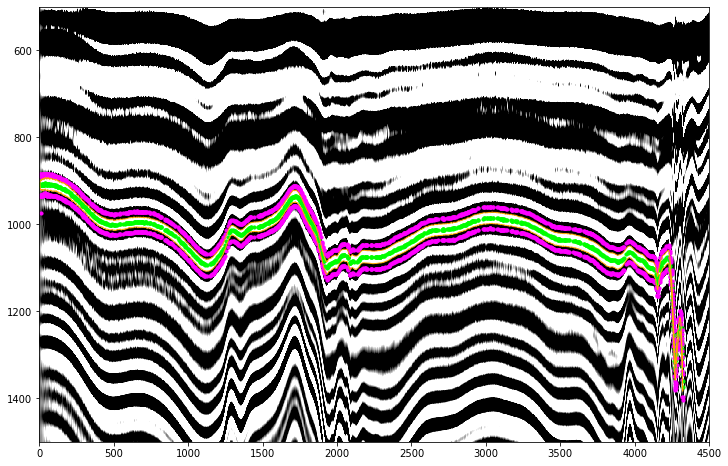

In [23]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

#plot contour
plt.plot(long_contours_subset[z][:, 1], long_contours_subset[z][:, 0], color='orange', linewidth=1)

#plot ridge and troughs
for i, x in enumerate(uniquex):
    y = ridge_points2[i]
    t = top[i]
    b = bottom[i]
    ax.scatter(x, y, color='lime', marker='o', s=10)
    ax.scatter(x, t, color='magenta', marker='o', s=10)
    ax.scatter(x, b, color='magenta', marker='o', s=10)

ax.set_xlim(0, 4500)
ax.set_ylim(1500, 500)

plt.show()

#### Missing `find_contours()` method, for finding the actual contours

Eventually, this &#9660;&#9660;&#9660;&#9660; will need to be be its own method.

In [10]:
#save lists
argx_list = []
uniquex_list = []
saved_points_list = []

ridge_points_list = []
top, bottom = [], []
top_list, bottom_list = [], []

In [11]:
print(len(long_contours_subset))

78


### A check:
If the length of uniquex_list, saved_points_list, and ridge_points_list is not the same for a given point i, get rid of it.

In [12]:
for i, contour in enumerate(long_contours_subset):
    #get shape of data
    maxrows, maxcols = np.shape(data)
    
    #find x values for contour and where along that contour that x value occurs (aka, y values)
    uniquex, saved_points = find_contour_points(contour, argx_list)
    saved_points_list.append(saved_points)

    #find y values and ridge points for each contour
    ridge_points = []
    to_deletex = []
    
    ridge, to_deletex = find_ridge_points(contour, to_deletex, uniquex, saved_points, data, ridge_points)
    ridge_points_list.append(ridge)
    
    #now we need to delete the values that we couldn't find a ridge/trough value from
    #now they should be the same length
    uniquex = [x for x in uniquex if x not in to_deletex]    
    uniquex_list.append(uniquex)
        
    #find top and bottom troughs/peaks
    top, bottom = find_troughs(uniquex, ridge, data)
    top_list.append(top)
    bottom_list.append(bottom)
    
    print(i, argx_list[i], len(uniquex_list[i]), len(ridge_points_list[i]), len(saved_points_list[i]))

0 [1454, 0] 234 234 666
1 [6054, 12090] 1123 1123 4320
2 [31, 232] 108 108 108
3 [380, 2564] 665 665 721
4 [181, 369] 89 89 106
5 [5970, 11722] 1668 1668 4135
6 [968, 2134] 486 486 559
7 [3, 1259] 499 499 646
8 [403, 171] 53 53 53
9 [6773, 14001] 3848 3848 4246
10 [59, 1360] 489 489 662
11 [4018, 6631] 1314 1314 1927
12 [6751, 13543] 3638 3638 4257
13 [268, 746] 276 276 311
14 [96, 808] 403 403 517
15 [666, 1326] 181 181 278
16 [53, 1346] 304 304 665
17 [6541, 13093] 2234 2234 4262
18 [164, 329] 99 99 99
19 [1223, 3273] 1160 1160 1389
20 [623, 1229] 210 210 258
21 [52, 186] 82 82 90
22 [327, 1557] 311 311 650
23 [4002, 8009] 2195 2195 2467
24 [0, 6714] 1783 1783 4269
25 [326, 1563] 373 373 642
26 [72, 380] 32 32 54
27 [7357, 14178] 1328 1328 4265
28 [308, 1579] 549 549 638
29 [50, 306] 37 37 49
30 [584, 1963] 627 627 630
31 [9104, 16066] 4084 4084 4122
32 [33, 293] 41 41 47
33 [1779, 5919] 1573 1573 1573
34 [41, 171] 14 14 15
35 [10, 235] 37 37 37
36 [356, 1888] 631 631 631
37 [10149, 

I need to make this it's own method, maybe. There is a `plot_picks()` method in ImpDAR, though, so maybe not. The determining factor will be whether or not I can convect the t, r, b arrays for each contour into a pick.

````python
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

#plot grid
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

for i, contour in enumerate(long_contours_subset):
    #plot contours
    ax.plot(contour[:, 1], contour[:, 0], color='orange', linewidth=1)

    #plot ridge points
    ridge = ridge_points_list[i]
    uniqx = uniquex_list[i]
    top_ = top_list[i]
    bottom_ = bottom_list[i]
    
    for j, x in enumerate(uniqx):
        t = top_[j]
        r = ridge[j]
        b = bottom_[j]
        
        ax.scatter(x, t, color='lime', marker='o', s=10)
        ax.scatter(x, r, color='magenta', marker='o', s=10)
        ax.scatter(x, b, color='lime', marker='o', s=10)
        
    print('Done processing contour {}/{}'.format(i+1, len(long_contours_subset)))
    

ax.set_ylim(3000, 500)

plt.savefig('internal_reflectors1.pdf', format='pdf', bbox_inches='tight')
#plt.show()
````

This method is too time-consuming. Moving over to a trimmed-down Python command line version for output.